In [7]:
import sys
sys.path = ["../src"] + sys.path

In [13]:
import math

import cv2
import numpy as np
import tensorflow as tf
from matplotlib.image import imread
import matplotlib.pyplot as plt

from train import input_fn
from slim_models.preprocessing import vgg_preprocessing

%matplotlib inline

# Read image

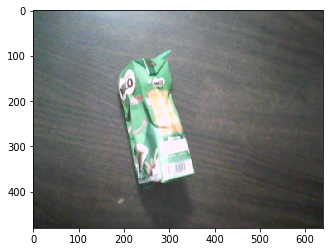

In [2]:
image_path = "/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h40m14s606.png"
image = cv2.imread(image_path)
image = image[:, :, ::-1]

plt.imshow(image)

In [3]:
image_pld = tf.placeholder(tf.uint8, shape=[None, None, 3])

# Flip left-right

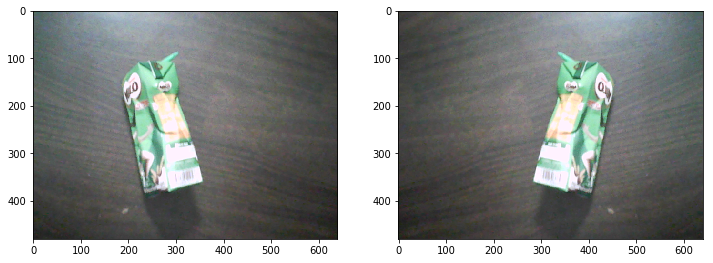

In [27]:
# image_flip_lr = tf.image.random_flip_left_right(image_pld)
image_flip_lr = tf.image.flip_left_right(image_pld)
with tf.Session() as sess:
    output = sess.run(image_flip_lr, feed_dict={image_pld: image})
    
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image)
axs[1].imshow(output)

# Flip up-down

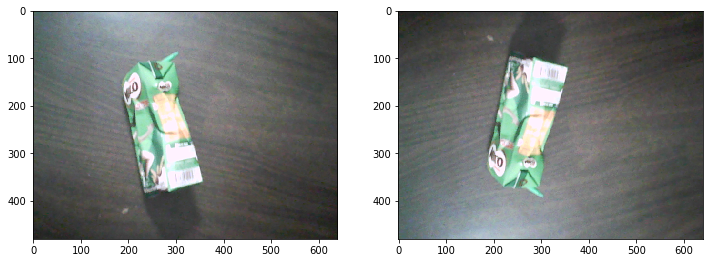

In [28]:
# image_flip_lr = tf.image.random_flip_up_down(image_pld)
image_flip_ud = tf.image.flip_up_down(image_pld)
with tf.Session() as sess:
    output = sess.run(image_flip_ud, feed_dict={image_pld: image})
    
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image)
axs[1].imshow(output)

# Color alteration

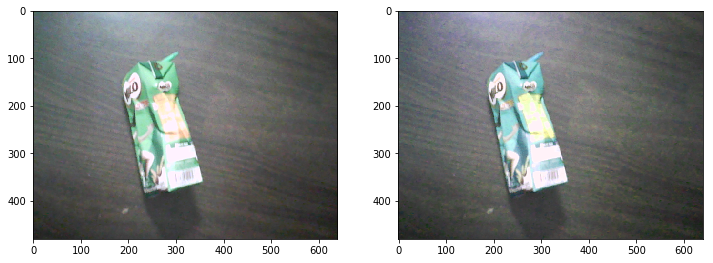

In [37]:
image_color = tf.image.random_hue(image_pld, max_delta=0.1)
with tf.Session() as sess:
    output = sess.run(image_color, feed_dict={image_pld: image})
    
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image)
axs[1].imshow(output)

# Rotation

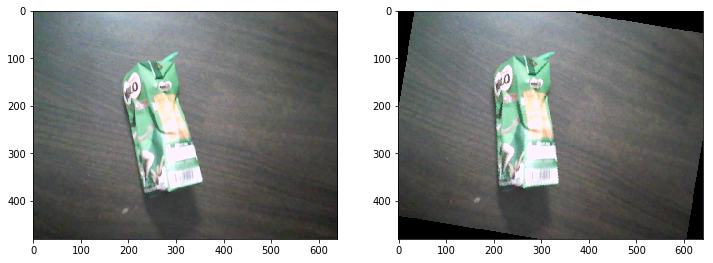

In [59]:
max_angle = 20
random_angles = tf.random_uniform([], minval=-max_angle * math.pi / 180., 
                                  maxval=max_angle * math.pi / 180.) 
image_rotate = tf.contrib.image.rotate(image, angles=random_angles)
with tf.Session() as sess:
    output = sess.run(image_rotate, feed_dict={image_pld: image})
    
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image)
axs[1].imshow(output)

# Scale

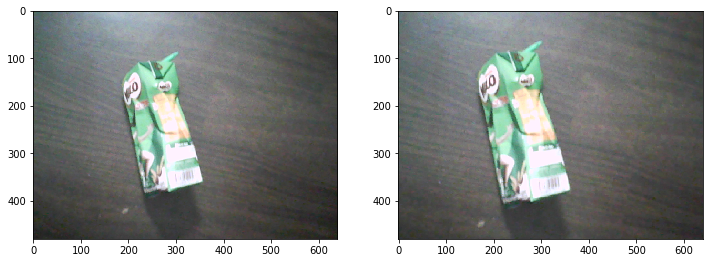

In [42]:
z = tf.exp(tf.random_uniform([], minval=np.log(1/1.3), maxval=np.log(1.3)))
image_shape = tf.shape(image)
ox, oy = image_shape[1], image_shape[0]
ox = tf.to_float(ox) / 2 + 0.5
oy = tf.to_float(oy) / 2 + 0.5
offset_matrix = [[1., 0., ox], [0., 1., oy], [0., 0., 1.]]
reset_matrix = [[1., 0., -ox], [0., 1., -oy], [0., 0., 1.]]
transform_matrix = [[z, 0., 0.], [0., z, 0.], [0., 0., 1.]]
transforms = tf.matmul(tf.matmul(offset_matrix, transform_matrix), reset_matrix)
transforms = tf.reshape(transforms, [-1])[:-1]
image_scale = tf.contrib.image.transform(image, transforms)
with tf.Session() as sess:
    output = sess.run(image_scale, feed_dict={image_pld: image})
    
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image)
axs[1].imshow(output)

# Adjust saturation

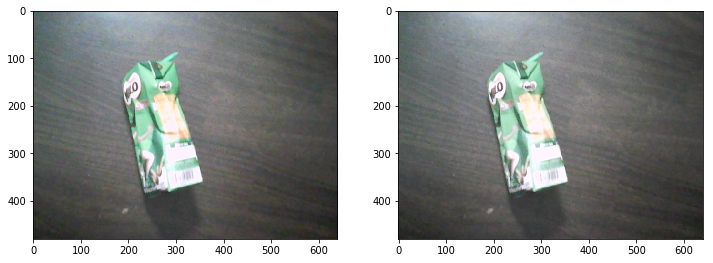

In [106]:
image_sat = tf.image.random_saturation(image, 0.3, 1.7)
with tf.Session() as sess:
    output = sess.run(image_sat, feed_dict={image_pld: image})
    
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image)
axs[1].imshow(output)

# Contrast

2.31357 1.39408 0.0175277


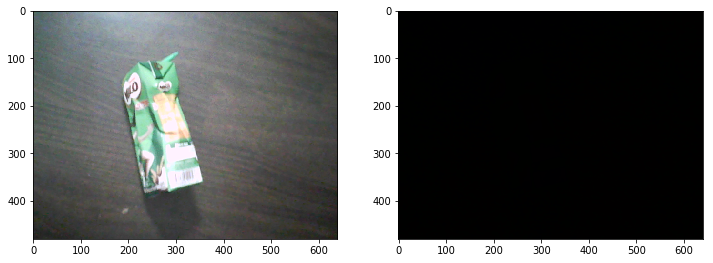

In [101]:
rand_power = tf.random_uniform([], minval=0.25, maxval=4.)
rand_factor = tf.random_uniform([], minval=0.7, maxval=1.4)
rand_offset = tf.random_uniform([], minval=-0.1, maxval=0.1)

hsv = tf.image.rgb_to_hsv(image)

hue = tf.slice(hsv, [0, 0, 0], [-1, -1, 1])
saturation = tf.slice(hsv, [0, 0, 1], [-1, -1, 1])
value = tf.slice(hsv, [0, 0, 2], [-1, -1, 1])

saturation = tf.pow(saturation, rand_power) * rand_factor + rand_offset
saturation = tf.clip_by_value(saturation, 0.0, 1.0)
value = tf.pow(value, rand_power) * rand_factor + rand_offset
value = tf.clip_by_value(value, 0.0, 1.0)

hsv_altered = tf.concat([hue, saturation, value], 2)

image_contrast = tf.image.hsv_to_rgb(hsv_altered)
with tf.Session() as sess:
    output, p, f, o = sess.run([image_contrast, rand_power, rand_factor, rand_offset], feed_dict={image_pld: image})
    print(p, f, o)
    
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image)
axs[1].imshow(output.astype(np.uint8))

# Visualize training set augmentation

In [43]:
mean = np.array([vgg_preprocessing._R_MEAN, 
                 vgg_preprocessing._G_MEAN, 
                 vgg_preprocessing._B_MEAN]).reshape((1, 1, 1, -1))
f, l = input_fn("../data/interim/merged_v2/recycle-train-*", is_training=True, batch_size=32)
with tf.Session() as sess:
    try:
        a, b = sess.run([f, l])
        imgs = a["image"]
        imgs += mean
#         axs[i].imshow(img)
#         axs[i].set_title(exp_predictions[i][0] + " " + str(exp_predictions[i][1]))
    except Exception as e:
        print(e)

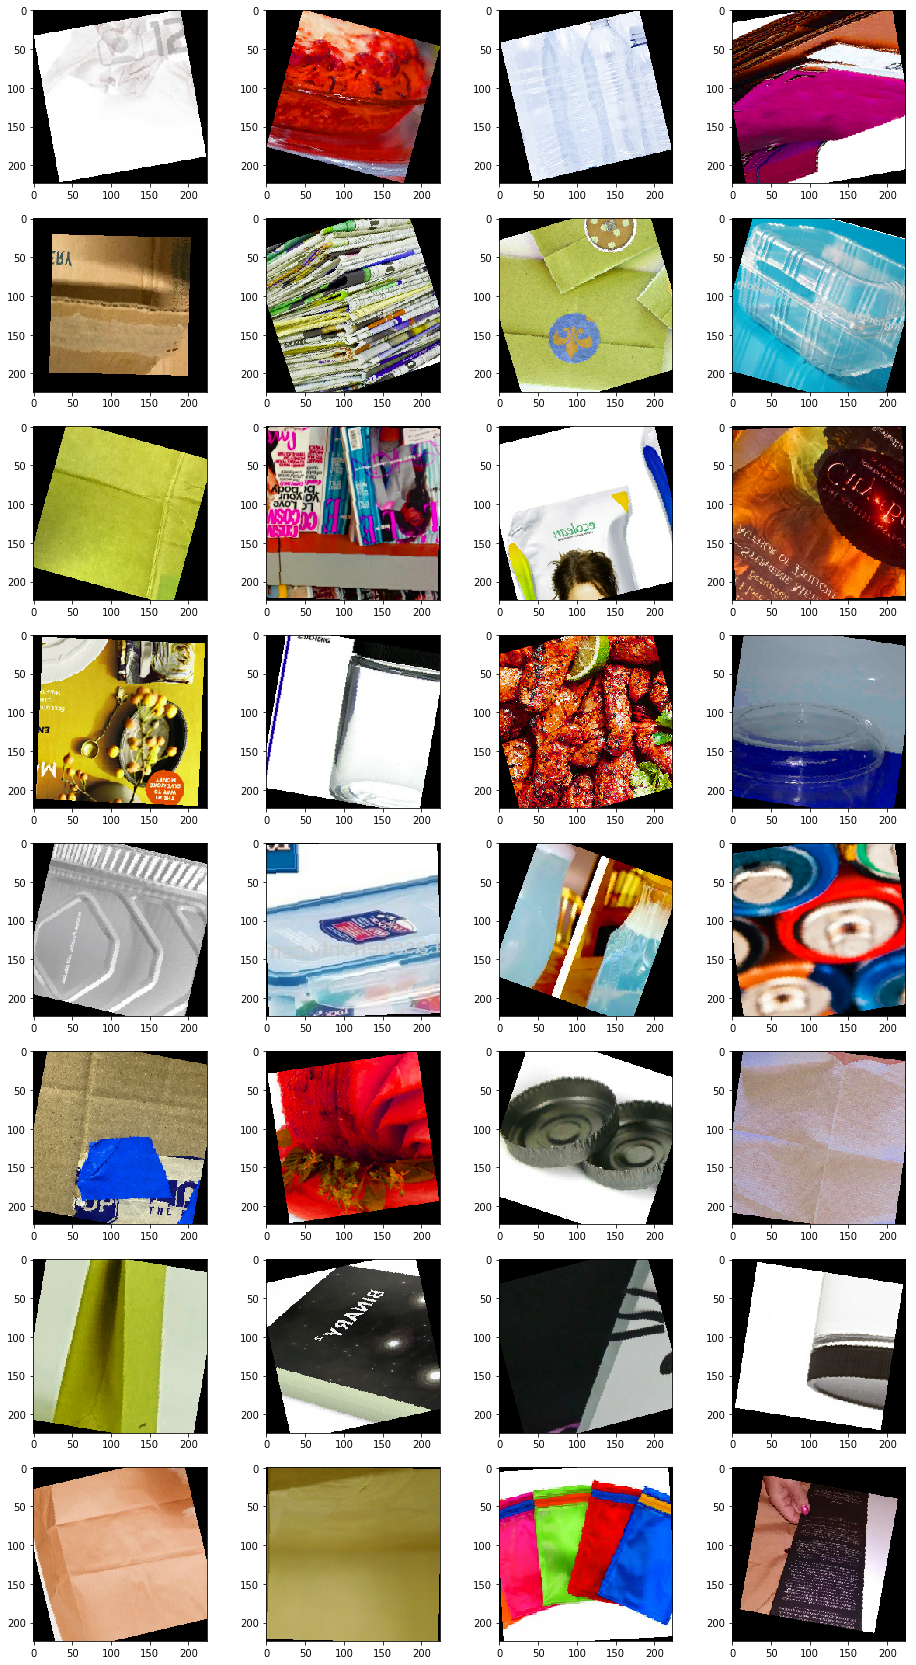

In [44]:
fig, axs = plt.subplots(8, 4, figsize=(16, 30))
for i in range(8):
    for j in range(4):
        axs[i, j].imshow(imgs[4 * i + j].astype(np.uint8))